In [1]:
import numpy as np
import xgboost as xgb
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import json
from sklearn import preprocessing
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingClassifier as GBT
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import pytz
import pickle
%matplotlib inline

#from sklearn.preprocessing import CategoricalEncoder
#CategoricalEncoder is part of sklearn's developer version, which you can't just update with conda. If you have issues
#getting this version, try a hard code implementation of the library here - https://pastebin.com/qs1es9XE

In [2]:
#reads a weird json, and returns the bids dataframe and ads dataframe
def read_weird_json(path):
    bids = []
    ads = []

    with open(path) as f:
        for line in f:
            line_dict = json.loads(line.encode('utf-8'))
            if 'advertiser_id' in line_dict:
                if line_dict['rate_metric'] != 'CPC':
                    continue
                ads.append(line_dict)
            else:
                bids.append(line_dict)
    df_bids = pd.DataFrame.from_records(bids)
    df_ads = pd.DataFrame.from_records(ads)  
    
    return [df_bids, df_ads]

#Returns a list of dataframes. Only looks at ads. 
def read_many_jsons(paths): 
    dfs = []
    for path in paths: 
        dfs += [read_weird_json(path)[1]]
    return dfs

## Load in the data for the training set

In [3]:
#Open our hdf files
neg2 = pd.HDFStore('./data/day2_negatives_processed.h5')
neg3 = pd.HDFStore('./data/day3_negatives_processed.h5')
# neg4 = pd.HDFStore('./data/day4_negatives_processed.h5')

pos2 = pd.HDFStore('./data/day2_positives_processed.h5')
pos3 = pd.HDFStore('./data/day3_positives_processed.h5')
# pos4 = pd.HDFStore('./data/day4_positives_processed.h5')

#Load out dataframes
df_neg2 = neg2['df']
df_neg3 = neg3['df']
# df_neg4 = neg4['df']

df_pos2 = pos2['df']
df_pos3 = pos3['df']
# df_pos4 = pos4['df']

#Close our hdf files
neg2.close()
neg3.close()
# neg4.close()

pos2.close()
pos3.close()
# pos4.close()

df_neg2.shape, df_neg3.shape, df_pos2.shape, df_pos3.shape

((350926, 39), (368002, 39), (604190, 39), (604190, 39))

## Load in the data for the testing set

In [4]:
test = pd.HDFStore('./data/test.h5')
test_df = test['df']
test.close() 
test_df.shape

(1570215, 46)

## DO NOT RELOAD DATA

### Concatenates both the positive and negative dataframes together

In [5]:
negatives = [df_neg2, df_neg3]

neg_df = pd.concat(negatives)

neg_df.shape

(718928, 39)

In [6]:
positives = [df_pos2, df_pos3]

pos_df = pd.concat(positives)

pos_df.shape

(1208380, 39)

In [7]:
train_df_pos = pos_df[:718928]
train_df_neg = neg_df
trains = [train_df_pos, train_df_neg]
train_df = pd.concat(trains)
train_df.shape

(1437856, 39)

In [8]:
# Only keep the columns that are in both the training and testing datasets -- TODO: remove this after processing
intersection = np.intersect1d(train_df.columns, test_df.columns)

train_df = train_df[intersection]
test_df = test_df[intersection]
train_df.shape, test_df.shape 

((1437856, 36), (1570215, 36))

In [9]:
total_df = pd.concat([train_df, test_df])

## DO NOT RUN

## DO NOT RUN

## DO NOT RUN

In [10]:
feature_map = []

One hot encoding function needs to be change - TODO 

In [11]:
def transform_column(df, col, thresh=200):
    if col in numerical_features:
        print("Numerical" , col)
        feature_map.append(col)
        return df[col].values.reshape(-1,1)
    
    print(col, df[col].nunique())
    
    if df[col].nunique() > thresh:
        df_frequency = df[[col, 'c_cnt']].groupby(col).agg('count').sort_values('c_cnt',ascending=False)
#         print("Total len: ", len(df_frequency))
#         print("SORTED: ", sorted(df_frequency))
#         print("SORTED INDEXED: ", sorted(df_frequency.iloc[0:thresh].index.values))
        cat = [sorted(df_frequency.iloc[0:thresh].index.values)]
        dict2 = {}
        for i, item in enumerate(cat[0]):
            feature_map.append(col + " - " + str(item))
            dict2[item] = i
        #enc = CategoricalEncoder(categories=[sorted(df_frequency[0:thresh].index.values)],handle_unknown='ignore')
    else:
        dict2 = {}
        i = 0
        for item in df[col].values:
            if item not in dict2:
                feature_map.append(col + " - " + str(item))
                dict2[item] = i
                i+=1
        #enc = CategoricalEncoder(categories='auto',handle_unknown='ignore')
    return [[1 if j == i else 0 for j in dict2] for i in df[col].values]

Now, we need to do some data cleaning. From some initial exploratory analysis, we can see that that we have 5 features with only 16 non-nan values, with a few other features having a similarly low level of non-nan values. To simplify things, we choose to drop all features with less than some threshhold of non-nan values. Also, as we are trying to predict c_cnt, samples where c_cnt is NaN are useless, so we throw those away as well. 

After this, we see that less than 10% of our remaining samples contains any NaN values, so we just drop those samples as we don't lose that much information from them.

In [12]:
print(total_df.isna().any())
# print(train_df.count())
n = len(total_df)

#filter rows with c_cnt as NaN
total_df = total_df[np.isfinite(total_df['c_cnt'])]

#filter threshhold
total_df = total_df.dropna(thresh=int(0.5*n), axis=1)

#drop all samples with NaN values
total_df = total_df.dropna(axis=0)

total_df.shape

_host                  False
ad_network_id          False
advertiser_id          False
c_cnt                  False
c_flag_cnt             False
campaign_id            False
campaign_type          False
f_cnt                  False
geo_city_name          False
geo_country_code3      False
geo_region_name        False
geo_timezone           False
i_cnt                  False
i_flag_cnt             False
i_timestamp            False
pub_network_id         False
r_cnt                  False
r_num_ads_requested    False
r_num_ads_returned     False
r_timestamp            False
rate_metric            False
referer                False
session_id             False
site_id                False
token                  False
ua                     False
ua_device              False
ua_device_type         False
ua_major               False
ua_minor               False
ua_os_name             False
url                    False
user_agent             False
uuid                   False
vi_cnt        

(3008071, 36)

Now, we have some more preprocessing to do, so we wrote some simple functions for preprocessing. The most important thing we do here is that since most of our features are categorical, we must encode them with one-hot-encoding, which essentially turns one feature into n different features, one for each type of class in the original features. For example, if we had a feature for "hair color", we would map it to a higher dimensional feature space consisting of "is the hair white", "is the hair black", "is the hair brown", etc. Only one of these features would be a 1, and the rest would be 0.

Normally, each feature would be mapped to n features, with n being the number of unique classes that feature contains. For our data, however, some features will have thousands, even millions of unique classes, which would result is an omega-sparse dataset. To account for this, we set a threshhold at 200, such that n will never be greater than 201. We still keep track of the 200 most frequent classes, however, the rest will be bunched into a single class. The motivation for this is that for the more frequent classes, we have enough data that our ML models will be able to extract some information, but for the less frequent classes, there is too little data for accurate analysis, so we group them as one class.

In [14]:
#Turns a timestamp into which minute the time was at - used as a categorical feature.
def timestamp_to_min(timestamp, is_hour=True):
    if is_hour:
        return timestamp.split(':')[0][-2:]
    else: 
        return timestamp.split(':')[1]

#plots frequency of a feature's different classes, useful for exploratory analysis
def plot_freq(col_name, df):
    df_frequency = df.groupby(col_name).agg('count').sort_values('ad_type',ascending=False)
    plt.plot([i for i in range(len(df_frequency.values))], [np.log(i[2]) for i in df_frequency.values])
    plt.show()

#if a feature only has one unique value, it tells us nothing, so we drop it.
def remove_only_ones(df):
    for col in df.columns:
        if len(df[col].unique()) == 1:
            print(col, " ", df[col].unique())
            df.drop(col, inplace=True,axis=1)

#just prints how many unique values are in each feature
def print_column_counts(df):    
    for i in df:
        print(i, df[i].nunique())

#We do some final cleaning, changing all non-numerical features into strings for later.
def preprocess(df):    
    for i in df:
        if i[-1] != 't' or i[-2] != 'n' or i[-3] != 'c':
            df[i] = df[i].astype('str')
    remove_only_ones(df)
#     print("2: ", df.columns)
    if 'site_id' in df.columns:
        df.drop('site_id',inplace=True,axis=1)
    df['i_timestamp'] = df['i_timestamp'].apply(timestamp_to_min)
    df['r_timestamp'] = df['r_timestamp'].apply(timestamp_to_min)
    

# print(train_df.c_cnt)
# print("1: ", train_df.columns)
#final preprocessing
# preprocess(train_df)
# preprocess(test_df)
preprocess(total_df)

# print("3: ", train_df.columns)
#this set contains our numerical column names
numerical_features = set(['c_cnt', 'i_cnt', 'r_cnt', 'vi_cnt'])
#we create a copy so that X will not include 'c_cnt'
# df2_train = train_df.copy()
# df2_train.drop('c_cnt',inplace=True,axis=1)

# df2_test = test_df.copy()
# df2_test.drop('c_cnt',inplace=True,axis=1)
df2 = total_df.copy()
df2.drop('c_cnt',inplace=True,axis=1)
#u,s,v = np.linalg.svd(X)

In [15]:
def fix_class_imbalance_with_subsampling(tempX, tempY, pos_ratio=2):
    tempY = tempY.reshape(-1,1)
    ind_1, ind_0 = [], []
    for i, y_h in enumerate(tempY):
        if y_h: ind_1.append(i)
        else: ind_0.append(i)
    to_sample = np.random.permutation(pos_ratio*len(ind_1))
    to_sample_0 = [ind_0[i] for i in to_sample]
    X2 = np.vstack([tempX[ind_1],tempX[to_sample_0]])
    Y2 = np.vstack([tempY[ind_1],tempY[to_sample_0]])
    tempY = tempY.reshape(-1)
    
    new_ind = np.random.permutation(len(X2))
    return X2[new_ind],Y2[new_ind]

#given a categorical column, we apply our earlier strategy of one-hot-encoding with maximum thresh=200
def transform_column(df, col, thresh=200, return_labels=False):
    print(col)
    df_frequency = df[[col, 'c_cnt']].groupby(col).agg('count').sort_values('c_cnt',ascending=False)
    if df[col].nunique() > thresh:
        enc = CategoricalEncoder(categories=[sorted(df_frequency[0:thresh].index.values)],handle_unknown='ignore')
        labels = df_frequency[0:thresh].index.values
    else:
        enc = CategoricalEncoder(categories=[sorted(df_frequency.index.values)],handle_unknown='ignore')
        labels = df_frequency.index.values
    labels = [str(col) + str(i) for i in labels]
    if return_labels:
        return labels
    enc.fit(df[col].values.reshape(-1, 1))
    return enc.transform(df[col].values.reshape(-1,1)).toarray()

Create our X and Y matrices - adjust threshhold values for 1HE here

In [17]:
print("hi")

hi


In [18]:
one_hot_thresh = 20

Y = total_df['c_cnt'].values


X = np.hstack([transform_column(total_df, col, thresh=one_hot_thresh) if col not in numerical_features else total_df[col].values.reshape(-1,1) for col in df2])

_host 145
ad_network_id 81
advertiser_id 147
c_flag_cnt 33
campaign_id 812
campaign_type 5
f_cnt 2
geo_city_name 38663
geo_country_code3 213
geo_region_name 388
geo_timezone 295
i_flag_cnt 60
i_timestamp 33
pub_network_id 16
r_num_ads_requested 9
r_num_ads_returned 10
r_timestamp 33
rate_metric 2
referer 176088
session_id 2788997
token 31352
ua 79095
ua_device 10726
ua_device_type 4
ua_major 157
ua_minor 84
ua_os_name 32
url 402053
user_agent 59409
uuid 1802282
vi_flag_cnt 18


In [21]:
X.shape, Y.shape

((3008071, 529), (3008071,))

In [20]:
X_train = X[:1437856]
X_test = X[1437856:]
y_train = Y[:1437856]
y_test = Y[1437856:]

X_fix , Y_fix = X_train, y_train#fix_class_imbalance_with_subsampling(X_train, y_train, pos_ratio=45)
Y_fix=Y_fix.ravel()

Custom training score for various paramters - Inverse of Euclidian Distance: Rewards both higher and less "extreme" values. Uses Precision of training as X and Recall as Y. 

In [22]:
def score(y_pred , y_test):
    test = confusion_matrix(y_test , y_pred)
    prec = test[1][1] / (test[1][1] + test[0][1])
    rec = test[1][1] / (test[1][1] + test[1][0])
    print("Precision: ", prec)
    print("Recall" , rec)
    return ((prec ** 0.5) * (rec ** 0.5))**2

In [23]:
dtrain = xgb.DMatrix(X_fix, label=Y_fix)
dtest = xgb.DMatrix(X_test)

In [24]:
max_depth = 10
eta = 0.3
num_rounds = 10
param = {'max_depth':max_depth, 'eta':eta, 'silent':0, 'eval_metric':'logloss', 'objective':'binary:logistic' }
bst = xgb.train(param, dtrain, num_rounds, verbose_eval=200)
preds = bst.predict(dtest)
y_pred = np.array([float(i) for i in np.round(preds)])
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')

In [25]:
print("Max depth: " + str(10) + " Eta: " + str(0.3) + " Precision: " + str(precision) + " Recall: " + str(recall))

Max depth: 10 Eta: 0.3 Precision: 0.00118497452305 Recall: 0.603174603175


In [26]:
confusion_matrix(y_test, y_pred)

array([[1088817,  480453],
       [    375,     570]])

In [27]:
score(y_pred, y_test)

Precision:  0.00118497452305
Recall 0.603174603175


0.00071474653771134403

## Running the cells below will take a lot of time

## STOP HERE

In [21]:
num_round = 10

max_depth_list = [x*10+10 for x in range(3)]
eta_list = [x*0.1+0.1 for x in range(9)]
for max_depth in max_depth_list: 
    for eta in eta_list: 
        param = {'max_depth':max_depth, 'eta':eta, 'silent':0, 'eval_metric':'logloss', 'objective':'binary:logistic' }
        bst = xgb.train(param, dtrain, num_round, verbose_eval=200)
        preds = bst.predict(dtest)
        y_pred = np.array([float(i) for i in np.round(preds)])
        precision = precision_score(y_test, y_pred, average='binary')
        recall = recall_score(y_test, y_pred, average='binary')
        print("Max depth: " + str(max_depth) + " Eta: " + str(eta) + " Precision: " + str(precision) + " Recall: " + str(recall))

Max depth: 10 Eta: 0.1 Precision: 1.0 Recall: 0.999700089973
Max depth: 10 Eta: 0.2 Precision: 1.0 Recall: 0.999700089973
Max depth: 10 Eta: 0.30000000000000004 Precision: 1.0 Recall: 0.999700089973
Max depth: 10 Eta: 0.4 Precision: 1.0 Recall: 0.999700089973
Max depth: 10 Eta: 0.5 Precision: 1.0 Recall: 0.999700089973
Max depth: 10 Eta: 0.6 Precision: 1.0 Recall: 0.999700089973
Max depth: 10 Eta: 0.7000000000000001 Precision: 1.0 Recall: 0.999700089973
Max depth: 10 Eta: 0.8 Precision: 1.0 Recall: 0.999700089973
Max depth: 10 Eta: 0.9 Precision: 1.0 Recall: 0.999700089973
Max depth: 20 Eta: 0.1 Precision: 1.0 Recall: 0.999700089973
Max depth: 20 Eta: 0.2 Precision: 1.0 Recall: 0.999700089973
Max depth: 20 Eta: 0.30000000000000004 Precision: 1.0 Recall: 0.999700089973
Max depth: 20 Eta: 0.4 Precision: 1.0 Recall: 0.999700089973
Max depth: 20 Eta: 0.5 Precision: 1.0 Recall: 0.999700089973
Max depth: 20 Eta: 0.6 Precision: 1.0 Recall: 0.999700089973
Max depth: 20 Eta: 0.7000000000000001 

## STOP HERE

## STOP HERE

## STOP HERE

In [77]:
param = {'max_depth':10, 'eta':0.1, 'silent':0, 'eval_metric':'logloss', 'objective':'binary:logistic' }
bst = xgb.train(param, dtrain, num_round, verbose_eval=200)
preds = bst.predict(dtest)
confusion_matrix(y_test, np.round(preds))
# precision = precision_score(y_test, y_pred, average='binary')
# recall = recall_score(y_test, y_pred, average='binary')
# print("Max depth: " + str(max_depth) + " Eta: " + str(eta) + " Precision: " + str(precision) + " Recall: " + str(recall))

array([[32792,    68],
       [    8,     0]])

In [54]:
preds = bst.predict(dtest)

In [57]:
confusion_matrix(y_test, np.round(preds))

array([[32674,   186],
       [    8,     0]])

In [63]:
y_test

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [70]:
y_pred = np.array([float(i) for i in np.round(preds)])
y_pred

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [71]:
sum(y_pred == y_test)

32674

In [69]:
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
precision, recall

(0.0, 0.0)

## KUSHS MODEL

## KUSHS MODEL

## KUSHS MODEL

## DO NOT RUN

In [25]:
model = xgb.XGBClassifier()

model.fit(X_fix ,Y_fix )

model.predict(X_train)

# confusion_mat

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [18]:
model = xgb.XGBClassifier(objective = "binary:logistic")
model.fit(X_fix ,Y_fix )
y_pred = model.predict(X_test)
#confusion_matrix(y_test,y_pred)
set(y_pred)

{0.0, 1.0}

In [19]:
y_pred = model.predict(X_test)
fs = f1_score(y_test,y_pred)
fs

0.019704433497536946

### 

In [20]:

scoresRat = []
for rat in [10,20,30,40,50]:
    X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.3)
    X_fix , Y_fix = fix_class_imbalance_with_subsampling(X_train, y_train, pos_ratio=rat)
    Y_fix=Y_fix.ravel()
    mdl = xgb.XGBClassifier()
    mdl.fit(X_fix , Y_fix)
    y_pred = mdl.predict(X_test)
    fs = f1_score(y_test,y_pred)
    scoresRat.append(fs)
    print("Rat", rat , " " , fs)



Rat 10   0.00378071833648
Rat 20   0.0
Rat 30   0.013986013986
Rat 40   0.047619047619
Rat 50   0.0


In [29]:
best_feats = [feature_map[i] for i in np.argsort(mdl.feature_importances_)[-20:]]



In [51]:
list(pd.Series(best_feats).value_counts()[:30].index)

['geo_dma_code - 618.0',
 'ua_device - Generic Smartphone',
 '_host - an-prod-ralphie-frontline-fleys.us-east-1',
 'ad_network_id - 1349',
 'i_timestamp - 16',
 'ua_os_name - iOS',
 'ua_major - 65',
 'ua_name - Mobile Safari',
 'geo_timezone - America/Los_Angeles',
 '_host - an-prod-ralphie-frontline-bedim.us-east-1',
 'ua_minor - 2',
 'vi_cnt',
 'ua_name - Firefox Mobile',
 'ua_major - 10',
 'ua_major - 8',
 'ua_major - 11',
 '_host - an-prod-ralphie-frontline-laris.us-east-1',
 'ua_os - iOS 9.3',
 'referer - http%3A%2F%2Fwww.breitbart.com%2F',
 'ua_device - iPad']

In [74]:
def featgood(colname , value):
    camp = df[df[colname] == value]
    with_feat = sum(camp["c_cnt"]) / len(camp)
    raw = sum(df["c_cnt"]) / len(df)
    print("Filtering for" , value , with_feat)
    #print("No filter" , raw)
    return with_feat

In [56]:
geo_count = df[df['geo_dma_code'] == '618.0']
len(geo_count)

5258

In [58]:
len(geo_count[geo_count['c_cnt'] == 1])/len(geo_count)

0.0003803727653100038

In [48]:
len(df[df['c_cnt'] == 1])/len(df)

0.00029207740051113545

In [76]:
for (index, item) in enumerate(best_feats):
    if item != 'vi_cnt':
        print("Feature: ", item)
        key, values = item.split(" - ")
        featgood(key, values)
    

Feature:  ua_os_name - iOS
Filtering for iOS 0.00035832369659755364
Feature:  i_timestamp - 16
Filtering for 16 0.0002703208500551039
Feature:  ua_minor - 2
Filtering for 2 0.00019325538699391245
Feature:  ua_major - 10
Filtering for 10 0.00011098779134295228
Feature:  ua_major - 8
Filtering for 8 0.0033003300330033004
Feature:  referer - http%3A%2F%2Fwww.breitbart.com%2F
Filtering for http%3A%2F%2Fwww.breitbart.com%2F 0.00026629976476854114
Feature:  ua_name - Firefox Mobile
Filtering for Firefox Mobile 0.0020491803278688526
Feature:  ua_device - Generic Smartphone
Filtering for Generic Smartphone 0.002145922746781116
Feature:  _host - an-prod-ralphie-frontline-laris.us-east-1
Filtering for an-prod-ralphie-frontline-laris.us-east-1 0.0003250623036081916
Feature:  _host - an-prod-ralphie-frontline-fleys.us-east-1
Filtering for an-prod-ralphie-frontline-fleys.us-east-1 0.0004345464421510049
Feature:  ua_major - 65
Filtering for 65 0.00015092631022903068
Feature:  geo_dma_code - 618.0
Fi

In [77]:
list(pd.Series(best_feats).value_counts()[:30].index)

['geo_dma_code - 618.0',
 'ua_device - Generic Smartphone',
 '_host - an-prod-ralphie-frontline-fleys.us-east-1',
 'ad_network_id - 1349',
 'i_timestamp - 16',
 'ua_os_name - iOS',
 'ua_major - 65',
 'ua_name - Mobile Safari',
 'geo_timezone - America/Los_Angeles',
 '_host - an-prod-ralphie-frontline-bedim.us-east-1',
 'ua_minor - 2',
 'vi_cnt',
 'ua_name - Firefox Mobile',
 'ua_major - 10',
 'ua_major - 8',
 'ua_major - 11',
 '_host - an-prod-ralphie-frontline-laris.us-east-1',
 'ua_os - iOS 9.3',
 'referer - http%3A%2F%2Fwww.breitbart.com%2F',
 'ua_device - iPad']

In [78]:
click_rat = []
for i in df["ua_major"].value_counts().keys():
    click_rat.append(featgood("ua_major" , i))
featgood

Filtering for 11 0.00019665296650999981
Filtering for 65 0.00015092631022903068
Filtering for 10 0.00011098779134295228
Filtering for 64 0.00046425255338904364
Filtering for 9 0.0015228426395939086
Filtering for 6 0.0
Filtering for 59 0.0006724949562878278
Filtering for 63 0.0007627765064836003
Filtering for 3 0.0
Filtering for 7 0.0
Filtering for 60 0.0
Filtering for 8 0.0033003300330033004
Filtering for 58 0.0
Filtering for 61 0.002242152466367713
Filtering for 5 0.0
Filtering for 62 0.002331002331002331
Filtering for 4 0.0024691358024691358
Filtering for 2 0.0027100271002710027
Filtering for 55 0.0
Filtering for 56 0.0
Filtering for 48 0.0
Filtering for 49 0.0
Filtering for 38 0.0
Filtering for 57 0.0
Filtering for 50 0.0
Filtering for 28 0.0
Filtering for 30 0.0
Filtering for 52 0.0
Filtering for 15 0.0
Filtering for 33 0.0
Filtering for 45 0.0
Filtering for 51 0.0
Filtering for 53 0.015151515151515152
Filtering for 39 0.0
Filtering for 47 0.0
Filtering for 34 0.0
Filtering for 54 

<function __main__.featgood>

In [31]:
good_feats = []
for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.3)
    X_fix , Y_fix = fix_class_imbalance_with_subsampling(X_train, y_train, pos_ratio=50)
    Y_fix=Y_fix.ravel()
    mdl = xgb.XGBClassifier()
    mdl.fit(X_fix , Y_fix)

    for w in np.argsort(mdl.feature_importances_)[-20:]:
        good_feats.append(feature_map[w])
        print(feature_map[w])
    print(i, len(good_feats))
        




i_timestamp - 15
creative_id - 1814142
geo_timezone - America/Los_Angeles
ck - {"widget_type": ["image"]}
ua_os - Android 5.1
ua_device_type - TAB
ua - Mozilla/5.0 (iPad; CPU OS 11_2_6 like Mac OS X) AppleWebKit/604.5.6 (KHTML, like Gecko) Version/11.0 Mobile/15D100 Safari/604.1
geo_region_name - CA
geo_timezone - America/New_York
ua_os_name - iOS
ua_major - 10
referer - http%3A%2F%2Fwww.breitbart.com%2F
ua_os - iOS 9.3
i_timestamp - 16
_host - an-prod-ralphie-frontline-bulks.us-east-1
_host - an-prod-ralphie-frontline-bedim.us-east-1
ua_device - Generic Smartphone
ua_major - 11
vi_cnt
ad_network_id - 1349
0 20
ua_os - iOS 11.2
referer - http%3A%2F%2Fwww.breitbart.com%2Fbig-government%2F2018%2F04%2F01%2Fpolice-man-exposes-child-chicago-target-store-womens-bathroom%2F
referer - http%3A%2F%2Fwww.breitbart.com%2F
num_ads - 4.0
ua_minor - 0
ua_major - 8
_host - an-prod-ralphie-frontline-bedim.us-east-1
geo_dma_code - 618.0
_host - an-prod-ralphie-frontline-fleys.us-east-1
ua_name - Mobile 

ck - {"widget_type": ["image"]}
ua_os_name - iOS
ua_major - 63
ua_os - iOS 11.2
referer - http%3A%2F%2Fwww.breitbart.com%2Fbig-government%2F2018%2F04%2F01%2Fpolice-man-exposes-child-chicago-target-store-womens-bathroom%2F
ua_name - Mobile Safari
ad_network_id - 1349
num_ads - 6.0
ua_major - 10
referer - http%3A%2F%2Fwww.breitbart.com%2F
geo_region_name - CA
_host - an-prod-ralphie-frontline-bulks.us-east-1
i_timestamp - 16
ua_minor - 3
geo_timezone - America/New_York
ua_major - 11
geo_timezone - America/Chicago
ua_os - Android 5.0
vi_cnt
ua_device - iPad
15 320
ua_major - 65
ua_name - Chrome Mobile
num_ads - 4.0
ua_name - Chrome
ua_os - Android 7.0
_host - an-prod-ralphie-frontline-fleys.us-east-1
ua_device - iPad
geo_timezone - America/Chicago
ua_name - Mobile Safari
ad_network_id - 893
geo_dma_code - 803.0
_host - an-prod-ralphie-frontline-bulks.us-east-1
referer - http%3A%2F%2Fwww.breitbart.com%2F
geo_region_name - CA
geo_dma_code - 618.0
_host - an-prod-ralphie-frontline-orlon.us-e

<BarContainer object of 617 artists>

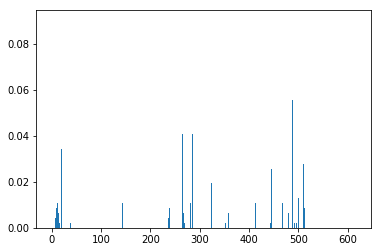

In [32]:
plt.bar(range(len(mdl.feature_importances_)), mdl.feature_importances_)

In [52]:
avgScores = []
for i in range(10): 
    X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.3)
    X_fix , Y_fix = fix_class_imbalance_with_subsampling(X_train, y_train, pos_ratio=45)
    Y_fix=Y_fix.ravel()
    mdl = xgb.XGBClassifier()
    mdl.fit(X_fix , Y_fix)
    y_pred = mdl.predict(X_test)
    s = f1_score(y_test,y_pred)
    print(i , s)
    avgScores.append(s)
avgScores











0 0.106382978723
1 0.139240506329
2 0.121546961326
3 0.0939597315436
4 0.0677966101695
5 0.220930232558
6 0.0952380952381
7 0.105263157895
8 0.133333333333
9 0.10152284264


[0.10638297872340426,
 0.13924050632911394,
 0.12154696132596685,
 0.093959731543624164,
 0.067796610169491525,
 0.22093023255813954,
 0.095238095238095233,
 0.10526315789473685,
 0.13333333333333333,
 0.10152284263959389]

In [53]:
sum(avgScores) / len(avgScores)

0.11852144497554998

Run PCA to condense the data to 80% of it's variance, but cut the featuers from 350 -> 30. This allows it to train faster later

In [47]:
pca = PCA(n_components = 0.8)
pca.fit(X_train)
X_train_small = pca.transform(X_train)
X_test_small = pca.transform(X_test)

Run a search across all possible paramters for RF in order to find one that maximizes score.

In [34]:


scores = []

for g in [0]:
    n_s = []
    for n_est in range(1):
        mdl = xgb.XGBClassifier(gamma = 0 , max_depth = 3)
        mdl.fit(X_fix , Y_fix)
        y_pred = mdl.predict(X_test)
        fs = f1_score(y_test,y_pred)
        n_s.append(fs)
        print("Score for gamma: " , g , " depth: " , n_est)
        score(y_pred , y_test)
    scores.append(n_s)












Score for gamma:  0  depth:  0
Precision:  0.00206832608231
Recall 0.456692913386


Plot the number of estimators (1,10 ,50 ,100) on the x-axis vs number of maximum number of features in a given tree (sqrt , lg2 , 10 , 30 , 50) : y-axis, in a heat map format to see which features provide highest accuracy. Use F1 metric to score models

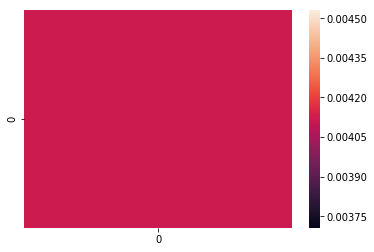

In [35]:
sns.heatmap(scores)

Looks like lg2 features did the most consistently and 50 estimators did the best. So use these for next grid search

Notes for reading confusion matrix

[0][0] correct non-clicked
[1][0] - Incorrect - ACTUALLY CLICK
[0][1] - Inccroect  - ACTUALLY NONCLICK
[1][1] - correct click


Do another grid search on Weighting and Max_depth. Trying to see if weighting the positive class will increase precision from last classifcation.

In [69]:


weight = {0:1 , 1:1}

scores = []

for weights in [0.001 , 0.1, 1,10,100,1000]:
    n_s = []
    for max_depths  in [1 , 10 , 100]:
        weight = {0:1 , 1:weights}
        mdl = RFC(max_features = "log2", n_estimators = 50 , class_weight = weight , max_depth= max_depths)
        mdl.fit(X_fix , Y_fix)
        y_pred = mdl.predict(X_test)
        fs = f1_score(y_test,y_pred)
        #print(fs)
        n_s.append(fs)
        score(y_pred , y_test)
       # n_s.append(score(y_pred , y_test))
    scores.append(n_s)












C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in longlong_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


Precision:  nan
Recall 0.0
Precision:  0.0170212765957
Recall 0.0155642023346
Precision:  0.00499873627454
Recall 0.692607003891


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in longlong_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


Precision:  nan
Recall 0.0
Precision:  0.0078125
Recall 0.105058365759
Precision:  0.0048440554092
Recall 0.665369649805
Precision:  0.0136612021858
Recall 0.0194552529183
Precision:  0.00740667588386
Recall 0.583657587549
Precision:  0.00485080940831
Recall 0.669260700389
Precision:  0.000596870725233
Recall 1.0
Precision:  0.00222275956996
Recall 0.929961089494
Precision:  0.00487977754757
Recall 0.696498054475
Precision:  0.000596870725233
Recall 1.0
Precision:  0.000604458409969
Recall 1.0
Precision:  0.00504574438592
Recall 0.708171206226
Precision:  0.000596870725233
Recall 1.0
Precision:  0.0006015917603
Recall 1.0
Precision:  0.00497582368155
Recall 0.688715953307


Heat map with weighting for positive class on y  [0.001 , 0.1, 1,10,100,1000] and max depth on X [1 , 10 , 100]. 

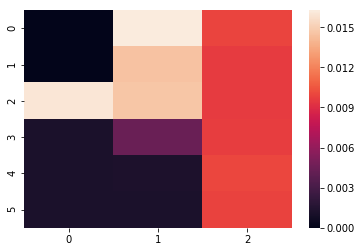

In [70]:
sns.heatmap(scores)

Best performace currently: max_features = "log2", n_estimators = 50 , class_weight: 0:1 , 1:0.001 , max_depth= 10)

In [82]:
mdl = RFC(max_features = "log2", n_estimators = 50 , class_weight = {0:1 , 1:1.5} , max_depth= 1)
mdl.fit(X_fix , Y_fix)
y_pred = mdl.predict(X_test)
score(y_pred , y_test)

Precision:  0.00721175516091
Recall 0.311284046693


0.0022449043302450707

Unfortunetly still has very poor performance on all paramters - next going to try seeing if changing the test ratio helps at all.

In [22]:
scores = []
mdl = RFC(max_features = "log2", n_estimators = 50 , class_weight = {0:1 , 1:1.5} , max_depth= 50)
for ratios in range(1,50):
    n_s = []
    X_fix , Y_fix = fix_class_imbalance_with_subsampling(X_train, y_train, pos_ratio=ratios)
    Y_fix=Y_fix.ravel()
    mdl.fit(X_fix , Y_fix)
    y_pred = mdl.predict(X_test)
    fs = f1_score(y_test,y_pred)
    n_s.append(fs)
    score(y_pred , y_test)
    scores.append(n_s)



Precision:  0.00241677614456
Recall 0.819327731092
Precision:  0.00376950932848
Recall 0.747899159664
Precision:  0.0047451619358
Recall 0.697478991597
Precision:  0.00528900642236
Recall 0.647058823529
Precision:  0.00621813207313
Recall 0.63025210084
Precision:  0.00687351759524
Recall 0.596638655462
Precision:  0.00710450675199
Recall 0.550420168067
Precision:  0.00734394124847
Recall 0.504201680672
Precision:  0.00839694656489
Recall 0.508403361345
Precision:  0.00845219228737
Recall 0.470588235294
Precision:  0.00878612716763
Recall 0.478991596639
Precision:  0.00930026572188
Recall 0.441176470588
Precision:  0.00878449345937
Recall 0.386554621849
Precision:  0.0098433530906
Recall 0.390756302521
Precision:  0.0106933813597
Recall 0.399159663866
Precision:  0.0108903781714
Recall 0.382352941176
Precision:  0.0109730301428
Recall 0.348739495798
Precision:  0.0107719928187
Recall 0.327731092437
Precision:  0.0107302533532
Recall 0.302521008403
Precision:  0.0113053964426
Recall 0.31

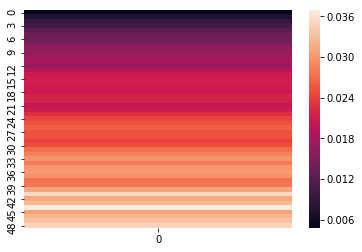

In [23]:
sns.heatmap(scores)

In [24]:
def feature_scoring_random_subsample(lst, df, model, oh_thresh, resample_thresh, p=0.3, iterations=10000):
    transformed_col, past_score = {}, {}
    for col in df.columns:
        if col == 'c_cnt': continue
        if col not in numerical_features:
            transformed_col[col] = transform_column(df, col, thresh=oh_thresh)
    Y = df['c_cnt'].values
    scores = []
    for i in range(iterations):
        print("Iteration: ", i)
        #subsample random columns with probability p
        selected = [c for c in df.columns if random.random() < p and c != 'c_cnt']
        print(selected)
        #if we have no items, super unlucky, try again
        if len(selected) < 1: continue
        X = np.hstack([transformed_col[col] if col not in numerical_features else df[col].values.reshape(-1,1)
                   for col in selected])
        remove_corr_features(X, None)
        X_train, Y_train, X_test, Y_test = test_train_split(X, Y)
        X_train, Y_train = fix_class_imbalance_with_subsampling(X_train, Y_train,pos_ratio=resample_thresh)

        lr = clone(model)
        lr.fit(X_train, Y_train)
        test_cm = confusion_matrix(Y_test, [i for i in lr.predict(X_test)])
        score = get_f1_score(test_cm)
        if math.isnan(score): continue
        scores.append((selected, score))
        
        if i > 0 and i % 100 == 0: #Updates score list every 100 iterations, and checks for convergence
            feature_scores = {}
            for f in df.columns:
                if f == 'c_cnt': continue
                feature_score = []
                for cols, score in scores:
                    if f in cols:
                        feature_score.append(score)
                feature_scores[f] = np.mean(feature_score)
            lst = []
            for feat in feature_scores:
                lst.append((feature_scores[feat], feat))
            lst = sorted(lst)
            lst.reverse()
            #check for convergence
            if i > 100:
                print(lst)
                has_conv = True
                for f in df.columns:
                    if f not in past_score or f not in feature_scores:
                        has_conv = False
                        break
                    if abs(past_score[f]-feature_scores[f])/feature_scores[f] > 0.01: has_conv = False
                if has_conv:
                    return lst
            past_score = feature_scores

In [97]:
scores = []
mdl = RFC(max_features = "log2", n_estimators = 100 , class_weight = {0:1 , 1:1.5} , max_depth= 100)
for ratios in range(1,150 , 10):
    n_s = []
    X_fix , Y_fix = fix_class_imbalance_with_subsampling(X_train, y_train, pos_ratio=ratios)
    Y_fix=Y_fix.ravel()
    mdl.fit(X_fix , Y_fix)
    y_pred = mdl.predict(X_test)
    fs = f1_score(y_test,y_pred)
    n_s.append(fs)
    score(y_pred , y_test)
    scores.append(n_s)



Precision:  0.0026712623869
Recall 0.768595041322
Precision:  0.00811568540652
Recall 0.454545454545
Precision:  0.011520335137
Recall 0.272727272727
Precision:  0.0125702059374
Recall 0.194214876033
Precision:  0.0143856920684
Recall 0.152892561983
Precision:  0.0147565174619
Recall 0.123966942149
Precision:  0.019524100061
Recall 0.132231404959
Precision:  0.020749665328
Recall 0.128099173554
Precision:  0.020999275887
Recall 0.119834710744
Precision:  0.0227081581161
Recall 0.111570247934
Precision:  0.0273327049953
Recall 0.119834710744
Precision:  0.0317286652079
Recall 0.119834710744
Precision:  0.0324449594438
Recall 0.115702479339
Precision:  0.0320987654321
Recall 0.107438016529
Precision:  0.0323834196891
Recall 0.103305785124


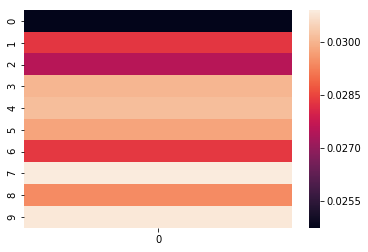